In [484]:
import numpy as np
import pyprop8 as pp
from pyprop8.utils import rtf2xyz, make_moment_tensor,stf_trapezoidal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d


In [485]:
#                                   Layer
#                                thickness Vp    Vs  Density
#                                    km   km/s  km/s  g/cm^3
model = pp.LayeredStructureModel([[ 3.00, 1.80, 0.00, 1.02],
                                  [ 2.00, 4.50, 2.40, 2.57],
                                  [ 5.00, 5.80, 3.30, 2.63],
                                  [20.00, 6.50, 3.65, 2.85],
                                  [np.inf,8.00, 4.56, 3.34]])
print(model)

------------------------------------------------------- z = 0.00 km
  vp = 1.80 km/s       FLUID        rho = 1.02 g/cm^3
------------------------------------------------------- z = 3.00 km
  vp = 4.50 km/s   vs = 2.40 km/s   rho = 2.57 g/cm^3
------------------------------------------------------- z = 5.00 km
  vp = 5.80 km/s   vs = 3.30 km/s   rho = 2.63 g/cm^3
------------------------------------------------------- z = 10.00 km
  vp = 6.50 km/s   vs = 3.65 km/s   rho = 2.85 g/cm^3
------------------------------------------------------- z = 30.00 km
  vp = 8.00 km/s   vs = 4.56 km/s   rho = 3.34 g/cm^3



In [486]:
nstations = 10
stations_xy = np.random.uniform(-50,50,size=[nstations,2])

Text(0, 0.5, 'South-North')

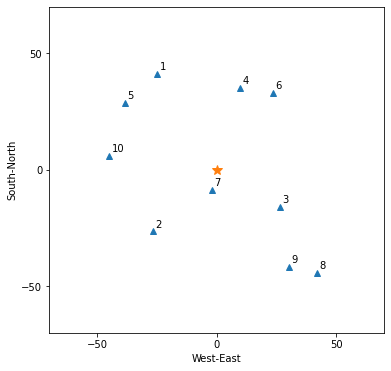

In [487]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(*stations_xy.T,marker='^',lw=0)
ax.plot([0],[0],marker='*',markersize=10)
for i in range(nstations):
    ax.text(stations_xy[i,0]+1,stations_xy[i,1]+1,"%i"%(i+1),verticalalignment='bottom',horizontalalignment='left')
ax.set_xlim(-70,70)
ax.set_ylim(-70,70)
ax.set_xticks([-50,0,50])
ax.set_yticks([-50,0,50])
ax.set_xlabel("West-East")
ax.set_ylabel("South-North")

In [488]:
receivers = pp.ListOfReceivers(*stations_xy.T,depth=3)

In [489]:
strike = 30
dip = 90
rake = 0
M0=1E7
depth = 15
moment_tensor = rtf2xyz(make_moment_tensor(strike, dip, rake, M0, 0, 0))
source = pp.PointSource(0,0,depth,moment_tensor,np.zeros([3,1]),0)

In [490]:
stf = lambda w: stf_trapezoidal(w, 3, 6)

In [491]:
nt = 80
delta_t = 0.5
time, seismograms = pp.compute_seismograms(model,source,receivers,nt,delta_t,source_time_function=stf)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 52.47it/s]


In [492]:
seismograms.shape

(10, 3, 80)

Text(0.5, 0, 'Time (s)')

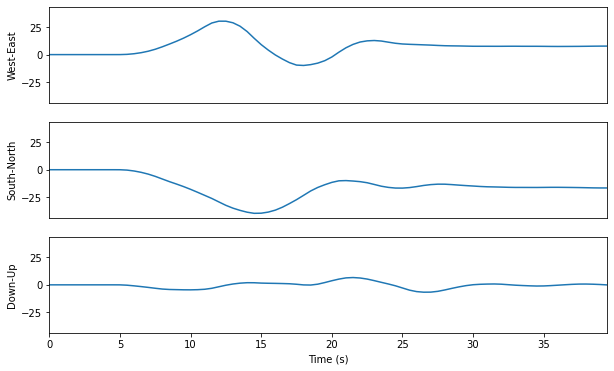

In [493]:
station_number = 1
irec = station_number - 1
fig,ax = plt.subplots(3,figsize=(10,6))
ax[0].plot(time,seismograms[irec,0,:])
ax[1].plot(time,seismograms[irec,1,:])
ax[2].plot(time,seismograms[irec,2,:])
[a.set_xticks([]) for a in ax[:-1]]
[a.set_xlim(0,(nt-1)*delta_t) for a in ax]
ylim = abs(seismograms[irec,:,:]).max()*1.1
[a.set_ylim(-ylim,ylim) for a in ax]
ax[0].set_ylabel("West-East")
ax[1].set_ylabel("South-North")
ax[2].set_ylabel("Down-Up")
ax[-1].set_xlabel("Time (s)")

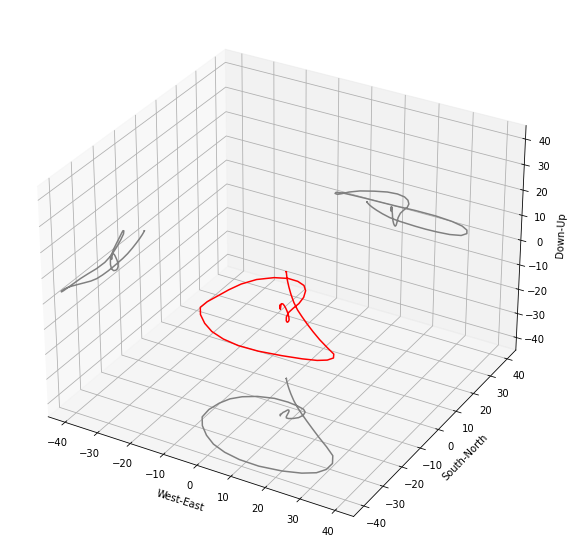

In [494]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot3D(seismograms[irec,0,:],seismograms[irec,1,:],seismograms[irec,2,:],color='red')
ax.set_xlim(-ylim,ylim)
ax.set_xlabel("West-East")
ax.plot3D(seismograms[irec,0,:],seismograms[irec,1,:],np.full(nt,-ylim),color='grey')
ax.set_ylim(-ylim,ylim)
ax.set_ylabel("South-North")
ax.plot3D(seismograms[irec,0,:],np.full(nt,ylim),seismograms[irec,2,:],color='grey')
ax.set_zlim(-ylim,ylim)
ax.set_zlabel("Down-Up")
ax.plot3D(np.full(nt,-ylim),seismograms[irec,1,:],seismograms[irec,2,:],color='grey')

In [602]:
receivers = pp.RegularlyDistributedReceivers(1,50,100,0,360,360,depth=3)
xx,yy = receivers.as_xy()

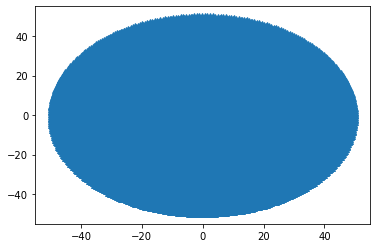

In [603]:
plt.plot(xx.flatten(),yy.flatten(),lw=0,marker='^')

In [604]:
static = pp.compute_static(model,source,receivers)

<function pyprop8._core.compute_spectra(structure, source, stations, omegas, derivatives=None, show_progress=True, stencil=<function kIntegrationStencil at 0x12dea0e50>, stencil_kwargs={'kmin': 0, 'kmax': 2.04, 'nk': 1200}, squeeze_outputs=True)>

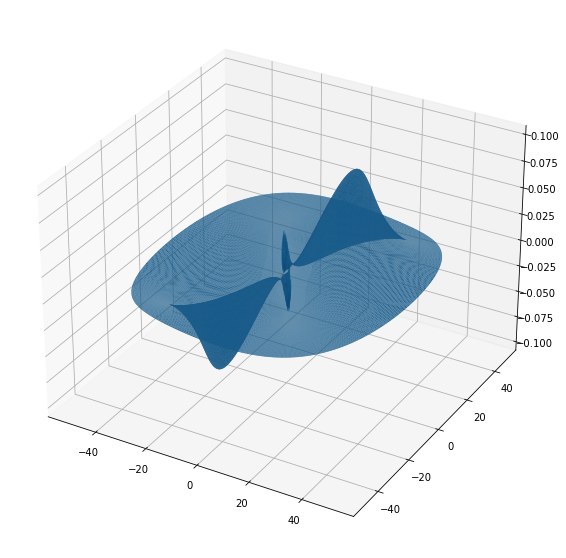

In [605]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
scale=0.1
scale2=0.001
ax.plot_trisurf((xx+scale*static[:,:,0]).flatten(),(yy+scale*static[:,:,1]).flatten(),scale2*static[:,:,0].flatten())

In [606]:
xx.shape

(100, 360)

In [607]:
static.shape

(100, 360, 3)

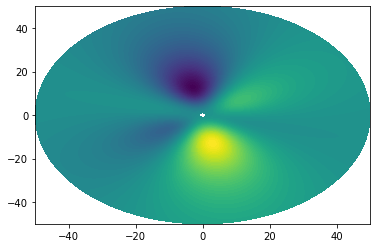

In [608]:
plt.contourf(xx,yy,static[:,:,1],100)

In [609]:
from matplotlib.tri import Triangulation, CubicTriInterpolator

In [610]:
rr = (xx**2+yy**2)**0.5

In [611]:
phph = np.arctan2(yy,xx)

In [627]:
tri = Triangulation((xx+0.0*static[:,:,0]).flatten(),(yy+0.0*static[:,:,1]).flatten())

In [628]:
ff = CubicTriInterpolator(tri,static[:,:,2].flatten())

In [629]:
gxx,gyy=np.meshgrid(np.linspace(-50,50,200),np.linspace(-50,50,200))

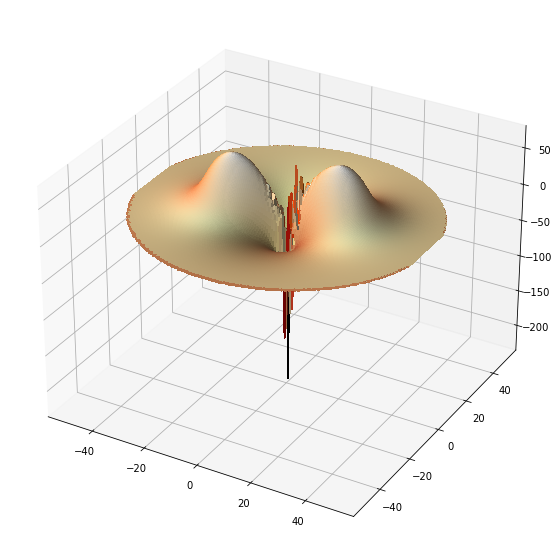

In [626]:

gzz=ff(gxx,gyy)
ls = LightSource(45, 45)
rgb = ls.shade(gzz, cmap=plt.cm.copper)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(gxx,gyy,gzz,facecolors=rgb,antialiased=False,rstride=1,cstride=1)

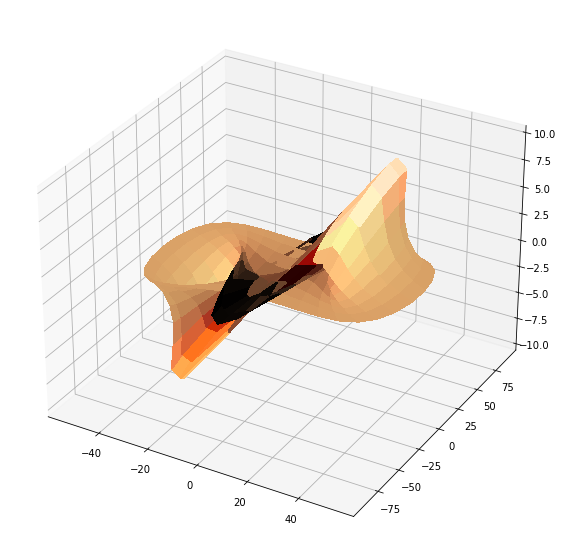

In [567]:
scale=0.2
scale2=0.1
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
from matplotlib.colors import LightSource
ls = LightSource(270, 45)
rgb = ls.shade(scale2*static[:,:,2], cmap=plt.cm.copper)
ax.plot_surface(xx+scale*static[:,:,0],yy+scale+static[:,:,1],scale2*static[:,:,0],facecolors=rgb,antialiased=False,shade=False)
#ax.plot_trisurf((xx+scale*static[:,:,0]).flatten(),(yy+scale*static[:,:,1]).flatten(),scale2*static[:,:,0].flatten()
#                ,triangles=tri.triangles,cmap=plt.cm.gray,antialiased=False,facecolors=rgb)

In [542]:
rgb.shape

(10, 36, 4)

In [555]:
ls = LightSource(270,45)

TypeError: Input z must be 2D, not 3D

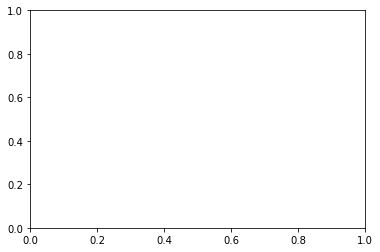

In [561]:
rgb = ls.shade(static[:,:,2],plt.cm.copper)


In [ ]:
Triangulation()